# PREDICTIVE MODELLING PROJECT



*   RONNIE CHAN
*   ANTONIO
*   Samuel

PROJECT REQUIREMENTS:

Use Kaggle BIRDS 510 SPECIES: https://www.kaggle.com/datasets/gpiosenka/100-bird-species
Make sure that your Training, Testing AND Validation sets contain the same classes of species
Your validation set is to be used at the very end -- to get a good sense of how your model is performing
You are expected to compile a CNN in order to correctly classify your selected 15 classes
Google Colab is your friend - it can help boost your model's training time
It can be beneficial to reshape some of the images to reduce some of the data, this will help speed up your model's training time
Do some research to find out ways to help boost your model's performance (ie data augmentation)
Make sure to save your model and during the presentation you will load your model and evaluate its performance on the validation set

# EXTENSION 

> KERAS_TUNER

> BATCH SIZE





# I - IMPORTS

In [1]:
import os
import numpy as np 
import pandas as pd 

import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report,ConfusionMatrixDisplay, f1_score, recall_score
from sklearn.neural_network import MLPClassifier  # Mulitple Layer of hidden Layers Perceptron


import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,initializers
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, BatchNormalization, Dropout, Activation
from keras import utils

!pip install keras-tuner -q
import keras_tuner



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 167.3/167.3 KB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.4 MB/s eta 0:00:00


# II- PATH SET UP
NOTE of reuse:

Set up a path
(Put the saved models under this path)

At this path, create a subfolder for the tuner and a sub-subfolder:
* path / tuner
* path / tuner / results

Indicate these 2 subfolders to the RandomSearch() method as :
directory="tuner",
project_name="results"

In [2]:
#run Only if connecting to google drive

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:

path = '/content/drive/MyDrive/BIRDS_510_SPECIES'
os.chdir(path)

os.getcwd()

'/content/drive/MyDrive/BIRDS_510_SPECIES'

# III - PRE-PROCESSOR

In [4]:
bird_list = ['AMERICAN AVOCET','ALTAMIRA YELLOWTHROAT','ALPINE CHOUGH','ALEXANDRINE PARAKEET','ALBERTS TOWHEE','ALBATROSS','AFRICAN PYGMY GOOSE','AFRICAN PIED HORNBILL','AFRICAN OYSTER CATCHER','AFRICAN FIREFINCH','AFRICAN EMERALD CUCKOO','AFRICAN CROWNED CRANE', 'ABYSSINIAN GROUND HORNBILL','ABBOTTS BOOBY','ABBOTTS BABBLER']

batch_size = 32 #Tuner_1: 32, Tuner_2: 64  


generator = keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255,
    horizontal_flip=True,
    vertical_flip=True
)

training = generator.flow_from_directory(
    path+'/train/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    seed=0,
    shuffle=True,
    classes=bird_list
)

validation = generator.flow_from_directory(
    path+'/valid/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    seed=0,
    shuffle=False,
    classes=bird_list
)

testing = generator.flow_from_directory(
    path+'/test/',
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='categorical',
    seed=0,
    shuffle=False,
    classes=bird_list
)




Found 2428 images belonging to 15 classes.
Found 75 images belonging to 15 classes.
Found 75 images belonging to 15 classes.


# IV - DISPLAY next bird of each folder

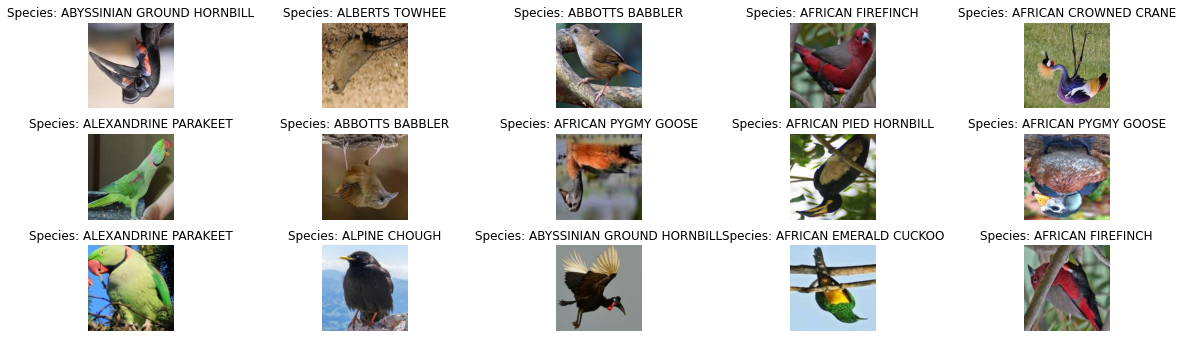

In [ ]:
bird_labels = [b for b in training.class_indices]
image_titles = training.__next__() #Iterator gets the next images in each training folders

images = image_titles[0] # Images
titles = image_titles[1] # categorized titles into a Sparse matrix
plt.figure(figsize = (20 , 20))

for i in range(15):
    plt.subplot(10 , 5, i+1)
    plt.subplots_adjust(hspace = 0.3 , wspace = 0.3)
    plt.imshow(images[i])
    plt.title(f'Species: {bird_labels[np.argmax(titles[i],axis=0)]}') # Search which index has a bit set to 1 in the sparse matrice
    plt.axis("off")

# V - FUNCTIONS

In [5]:
def plot_loss_accuracy(history,classifier):

  if type(history)==dict:
    dictio = history # After saving the fit history, the file is directly a dictionary
  else:
    dictio = history.history

  fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
  ax1.plot(dictio['loss'], label = 'Training Loss')
  ax1.plot(dictio['val_loss'], label = 'Validation Loss')
  ax1.set_title('Training Loss vs Validation Loss', fontsize = 11)
  ax1.legend()

  ax2.plot(dictio['accuracy'], label = 'Training Accuracy')
  ax2.plot(dictio['val_accuracy'], label = 'Validation Accuracy')
  ax2.set_title('Training Accuracy vs Validation Accuracy', fontsize = 11)
  ax2.legend();

  loss, accuracy = classifier.evaluate(testing)
  print('Loss', loss)
  print('Accuracy', accuracy)

In [6]:
def classif_report(classifier, testing=testing, training = training):
  testing.reset()

  pred=classifier.predict_generator(testing,verbose=1)
  predicted_class_indices=np.argmax(pred,axis=1)
  bird_labels = (training.class_indices)

  print(classification_report(testing.classes, predicted_class_indices, target_names = bird_labels))

# VI - CNN MANUAL OPTIMIZATION

## CNN Layers

In [7]:
num_classes = len(bird_list)
epochs=50

with tf.device('/device:GPU:0'):
    classifier_1 = Sequential()

    # hidden layer 1
    classifier_1.add(Conv2D(32, kernel_size=(5, 5), activation='relu', input_shape=(224,224,3), padding='same'))
    classifier_1.add(MaxPooling2D(pool_size=(2, 2)))
    classifier_1.add(BatchNormalization())
    classifier_1.add(Dropout(0.25))

    # hidden layer 2
    classifier_1.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
    classifier_1.add(MaxPooling2D(pool_size=(2, 2)))
    classifier_1.add(BatchNormalization())
    classifier_1.add(Dropout(0.25))

    # hidden layer 3
    classifier_1.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
    classifier_1.add(MaxPooling2D(pool_size=(2, 2)))
    classifier_1.add(BatchNormalization())
    classifier_1.add(Dropout(0.25))

    # hidden layer 4
    classifier_1.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
    classifier_1.add(MaxPooling2D(pool_size=(2, 2)))
    classifier_1.add(BatchNormalization())
    classifier_1.add(Dropout(0.25))


    # hidden layer 5
    classifier_1.add(Conv2D(512, kernel_size=(3, 3), activation='relu', padding='same'))
    classifier_1.add(MaxPooling2D(pool_size=(2, 2)))


    classifier_1.add(Flatten())

    # output layer
    classifier_1.add(Dense(1024, activation='relu'))
    classifier_1.add(Dense(512, activation='relu'))
    classifier_1.add(Dense(num_classes, activation='softmax'))

    classifier_1.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

classifier_1.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 112, 112, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0

## Model : Save / Load

In [8]:
# SAVE MODEL

#classifier_1.save(path+'/classifier_1')


In [16]:
# LOAD MODEL

classifier_1 = tf.keras.models.load_model(path+'/classifier_1')


## Model fitting

In [9]:

history_1 = classifier_1.fit(training, epochs=epochs, validation_data=validation)


Epoch 1/50
76/76 [==============================] - 1653s 22s/step - loss: 10.4313 - accuracy: 0.1301 - val_loss: 2.7501 - val_accuracy: 0.0667
Epoch 2/50
76/76 [==============================] - 11s 147ms/step - loss: 2.1308 - accuracy: 0.3143 - val_loss: 2.8235 - val_accuracy: 0.0667
Epoch 3/50
76/76 [==============================] - 11s 149ms/step - loss: 1.7597 - accuracy: 0.4213 - val_loss: 2.8418 - val_accuracy: 0.1067
Epoch 4/50
76/76 [==============================] - 11s 146ms/step - loss: 1.6007 - accuracy: 0.4753 - val_loss: 2.7565 - val_accuracy: 0.1200
Epoch 5/50
76/76 [==============================] - 12s 152ms/step - loss: 1.3865 - accuracy: 0.5404 - val_loss: 2.0990 - val_accuracy: 0.3067
Epoch 6/50
76/76 [==============================] - 12s 151ms/step - loss: 1.2281 - accuracy: 0.5844 - val_loss: 1.5399 - val_accuracy: 0.5333
Epoch 7/50
76/76 [==============================] - 11s 149ms/step - loss: 1.0854 - accuracy: 0.6417 - val_loss: 1.2439 - val_accuracy: 0.573

## History: Save / Load

In [11]:
# SAVE HISTORY

#np.save('classifier_1_history.npy',history_1.history)


In [12]:
# LOAD HISTORY

history_1_saved=np.load('classifier_1_history.npy',allow_pickle='TRUE').item()


## Accuracy

3/3 [==============================] - 0s 74ms/step - loss: 1.2999 - accuracy: 0.7467
Loss 1.2999430894851685
Accuracy 0.746666669845581


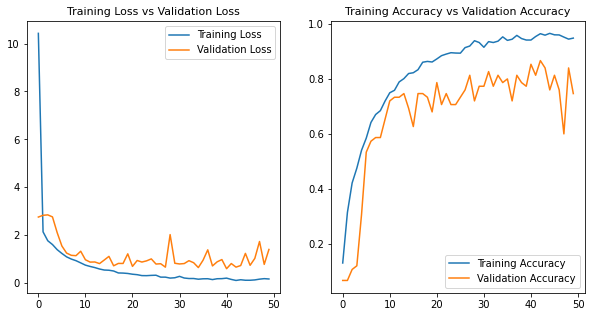

In [13]:

plot_loss_accuracy(history_1_saved,classifier_1)



In [14]:
classif_report(classifier_1)

<ipython-input-6-a88ff2ad379f>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=classifier.predict_generator(testing,verbose=1)


3/3 [==============================] - 0s 82ms/step
                            precision    recall  f1-score   support

           AMERICAN AVOCET       1.00      0.60      0.75         5
     ALTAMIRA YELLOWTHROAT       0.80      0.80      0.80         5
             ALPINE CHOUGH       1.00      1.00      1.00         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
            ALBERTS TOWHEE       0.56      1.00      0.71         5
                 ALBATROSS       0.75      0.60      0.67         5
       AFRICAN PYGMY GOOSE       0.71      1.00      0.83         5
     AFRICAN PIED HORNBILL       0.75      0.60      0.67         5
    AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
         AFRICAN FIREFINCH       0.83      1.00      0.91         5
    AFRICAN EMERALD CUCKOO       1.00      1.00      1.00         5
     AFRICAN CROWNED CRANE       1.00      0.60      0.75         5
ABYSSINIAN GROUND HORNBILL       0.56      1.00      0.71      

# VII - CNN AUTO TUNNING: KERAS_TUNER

## A- MODEL INSTRUMENTATION

In [7]:


def classifier_instrumentation(num_classes, units, activation, dropout, lr=None ):
    
    
  with tf.device('/device:GPU:0'):
      
      classifier = Sequential()

      # hidden layer 1
      classifier.add(Conv2D(units[0], kernel_size=(5, 5), activation=activation, input_shape=(224,224,3), padding='same'))
      classifier.add(MaxPooling2D(pool_size=(2, 2)))
      classifier.add(BatchNormalization())
      if dropout:
        classifier.add(layers.Dropout(0.25))

      # hidden layer 2
      classifier.add(Conv2D(units[1], kernel_size=(3, 3), activation=activation, padding='same'))
      classifier.add(MaxPooling2D(pool_size=(2, 2)))
      classifier.add(BatchNormalization())
      if dropout:
        classifier.add(layers.Dropout(0.25))

      # hidden layer 3
      classifier.add(Conv2D(units[2], kernel_size=(3, 3), activation=activation, padding='same'))
      classifier.add(MaxPooling2D(pool_size=(2, 2)))
      classifier.add(BatchNormalization())
      if dropout:
        classifier.add(layers.Dropout(0.25))

      # hidden layer 4
      classifier.add(Conv2D(units[3], kernel_size=(3, 3), activation=activation, padding='same'))
      classifier.add(MaxPooling2D(pool_size=(2, 2)))
      classifier.add(BatchNormalization())
      if dropout:
        classifier.add(layers.Dropout(0.25))


      # hidden layer 5
      classifier.add(Conv2D(units[4], kernel_size=(3, 3), activation=activation, padding='same'))
      classifier.add(MaxPooling2D(pool_size=(2, 2)))


      classifier.add(Flatten())

      # output layer
      classifier.add(Dense(units[5], activation='relu'))
      classifier.add(Dense(units[6], activation='relu'))
      classifier.add(Dense(num_classes, activation='softmax'))

      classifier.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
      # If learning rate is use, replace optimizer 'adam' param by:
      # optimizer=keras.optimizers.Adam(learning_rate=lr)

      classifier.summary()

      return classifier

In [8]:

num_classes = len(bird_list)
epochs=50 

def build_model(hp):
    #1stTrial:
    layer_1 = hp.Int("layer_1", min_value=32, max_value=512, step=32)
    layer_2 = hp.Int("layer_2", min_value=32, max_value=512, step=32)
    layer_3 = hp.Int("layer_3", min_value=32, max_value=512, step=32)
    layer_4 = hp.Int("layer_4", min_value=32, max_value=512, step=32)
    layer_5 = hp.Int("layer_5", min_value=32, max_value=512, step=32)
    output_layer_1 = hp.Int("output_layer_1", min_value=32, max_value=1024, step=32)
    output_layer_2 = hp.Int("output_layer_2", min_value=32, max_value=512, step=32)
    units = [layer_1,layer_2, layer_3,layer_4, layer_5,output_layer_1, output_layer_2 ]
    
    activation=hp.Choice("activation", ["relu", "tanh"])
    dropout = hp.Boolean("dropout")
    #lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    
    

    classifier = classifier_instrumentation(num_classes, units=units, activation=activation, dropout=dropout, lr=None)

    classifier.summary()

    return classifier

In [9]:

# Searching for the best model parameters
build_model(keras_tuner.HyperParameters())

tuner = keras_tuner.RandomSearch(
    hypermodel=build_model,
    objective="val_accuracy",
    max_trials=2,             #1st Trial: 3 | other Trials: 2
    executions_per_trial=2,
    overwrite=False,
    directory="tuner",
    project_name="results_41", #1st Trial: "results_1" | #4th Trial: "results_4" & #4th Trial: "results_41"
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      2432      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                        

## B- Tuner: 1st Trial
- Hyperparameters optimization: hidden Layers + Activation

Batch:
- 32

Tuner is set to:
- 3 Trials 
- 2 Executions per trial

### Launch Auto tunning

In [ ]:
# SEARCH PARAMETERS RECAP
tuner.search_space_summary()

Search space summary
Default search space size: 9
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
output_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
output_layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False

In [ ]:

tuner.search(training, epochs=epochs, validation_data=validation)


Trial 3 Complete [00h 18m 15s]
val_accuracy: 0.7400000095367432

Best val_accuracy So Far: 0.7400000095367432
Total elapsed time: 00h 57m 02s


In [ ]:
best_params_21 = tuner.get_best_hyperparameters()[0]
best_model_21 = tuner.get_best_models()[0]
for p,v in best_params_21.values.items():
  print(p,' : ', v, '\n')

classifier_21 = best_model_21

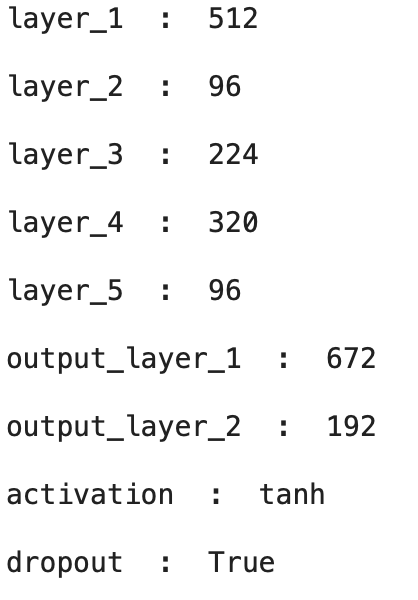

### CNN MODEL - Load / Sav

In [15]:
# EITHER LOAD MODEL
classifier_21 = tf.keras.models.load_model(path+'/tuner/classifier_21')

# OR 

# USE tuner's model 
#classifier_21 = best_model_21

In [ ]:
# SAVE MODEL

#classifier_21.save(path+'/tuner/classifier_21')


### Model fitting

In [ ]:
history_21 = classifier_21.fit(training, epochs=epochs, validation_data=validation)

### HISTORY - Load / Save

In [16]:
# LOAD HISTORY

history_21_saved=np.load(os.path.join(path+'/tuner', 'classifier_21_history.npy'),allow_pickle='TRUE').item()


Keras model archive loading:
File Name                                             Modified             Size
metadata.json                                  2023-03-26 04:19:38           64
config.json                                    2023-03-26 04:19:38         8617
variables.h5                                   2023-03-26 04:19:38     58812808
Keras weights file (<HDF5 file "variables.h5" (mode r)>) loading:
...layers
......batch_normalization
.........vars
............0
............1
............2
............3
......batch_normalization_1
.........vars
............0
............1
............2
............3
......batch_normalization_2
.........vars
............0
............1
............2
............3
......batch_normalization_3
.........vars
............0
............1
............2
............3
......conv2d
.........vars
............0
............1
......conv2d_1
.........vars
............0
............1
......conv2d_2
.........vars
............0
............1
......conv2d_3
.

In [ ]:
# SAVE HISTORY

#np.save(os.path.join(path+'/tuner', 'classifier_21_history.npy'), history_21)

## Accuracy Evaluation

3/3 [==============================] - 1s 129ms/step - loss: 1.3132 - accuracy: 0.6800
Loss 1.3132116794586182
Accuracy 0.6800000071525574


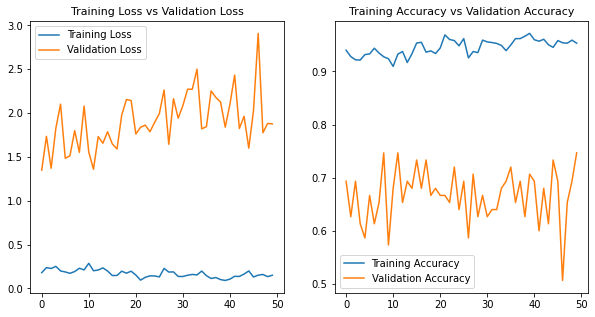

In [18]:
plot_loss_accuracy(history_21_saved,classifier_21)

In [20]:
classif_report(classifier_21)

<ipython-input-6-a88ff2ad379f>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=classifier.predict_generator(testing,verbose=1)


3/3 [==============================] - 1s 189ms/step
                            precision    recall  f1-score   support

           AMERICAN AVOCET       0.57      0.80      0.67         5
     ALTAMIRA YELLOWTHROAT       1.00      0.40      0.57         5
             ALPINE CHOUGH       1.00      0.40      0.57         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
            ALBERTS TOWHEE       1.00      0.60      0.75         5
                 ALBATROSS       0.67      0.80      0.73         5
       AFRICAN PYGMY GOOSE       0.71      1.00      0.83         5
     AFRICAN PIED HORNBILL       0.56      1.00      0.71         5
    AFRICAN OYSTER CATCHER       0.83      1.00      0.91         5
         AFRICAN FIREFINCH       0.80      0.80      0.80         5
    AFRICAN EMERALD CUCKOO       1.00      0.80      0.89         5
     AFRICAN CROWNED CRANE       0.00      0.00      0.00         5
ABYSSINIAN GROUND HORNBILL       0.57      0.80      0.67     

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## C-Tuner: 2nd Trial
Hyperparameters optimization

The last trial has demonstrated that the batch size plays a important role. 

1) Optimize hyperparameters on big batch / fit
- batch_size = 64 (see https://arxiv.org/pdf/1705.08741.pdf)
- epochs=50 
- 5 hidden Layers
- 2 output Layers

shorter execution time. Tuner to:
- 2 Trials
- 2 Executions per trial
2) Check Accuracy on smaller batch:
- batch_size = 32

### Launch Auto Tunning

In [10]:
# SEARCH PARAMETERS RECAP
tuner.search_space_summary()

Search space summary
Default search space size: 9
layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_3 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_4 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
layer_5 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
output_layer_1 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 1024, 'step': 32, 'sampling': 'linear'}
output_layer_2 (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'tanh'], 'ordered': False

In [11]:
tuner.search(training, epochs=epochs, validation_data=validation)

Trial 2 Complete [00h 13m 47s]
val_accuracy: 0.8866666555404663

Best val_accuracy So Far: 0.8866666555404663
Total elapsed time: 00h 59m 08s


In [12]:
best_model_24 = tuner.get_best_models()[0]

best_params_24 = tuner.get_best_hyperparameters()[0]
for p,v in best_params_24.values.items():
  print(p,' : ', v, '\n')


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 192)     14592     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 192)    0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 192)    768       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 112, 112, 192)     0         
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      55328     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0

### CNN MODEL - Load / Save

In [21]:
# EITHER LOAD MODEL
classifier_24 = tf.keras.models.load_model(path+'/tuner/classifier_24')

# OR 

# USE tuner's model 
#classifier_24 = best_model_24

In [14]:
#classifier_24.save(path+'/tuner/classifier_24')

### Model fitting

In [15]:
history_24 = classifier_24.fit(training, epochs=epochs, validation_data=validation)

Epoch 1/50
38/38 [==============================] - 12s 218ms/step - loss: 0.1039 - accuracy: 0.9666 - val_loss: 0.8406 - val_accuracy: 0.7467
Epoch 2/50
38/38 [==============================] - 8s 210ms/step - loss: 0.0927 - accuracy: 0.9695 - val_loss: 0.9505 - val_accuracy: 0.7733
Epoch 3/50
38/38 [==============================] - 8s 210ms/step - loss: 0.0901 - accuracy: 0.9679 - val_loss: 0.8779 - val_accuracy: 0.7867
Epoch 4/50
38/38 [==============================] - 8s 211ms/step - loss: 0.1414 - accuracy: 0.9539 - val_loss: 0.9158 - val_accuracy: 0.7867
Epoch 5/50
38/38 [==============================] - 8s 210ms/step - loss: 0.1366 - accuracy: 0.9555 - val_loss: 0.6595 - val_accuracy: 0.8533
Epoch 6/50
38/38 [==============================] - 8s 212ms/step - loss: 0.0824 - accuracy: 0.9732 - val_loss: 0.9036 - val_accuracy: 0.7867
Epoch 7/50
38/38 [==============================] - 8s 210ms/step - loss: 0.0958 - accuracy: 0.9691 - val_loss: 1.0567 - val_accuracy: 0.7333
Epoch

### HISTORY - Load / Save

In [16]:
# SAVE HISTORY

#np.save(os.path.join(path+'/tuner', 'classifier_24_history.npy'), history_24.history)


In [22]:
# LOAD HISTORY

history_24_saved = np.load(os.path.join(os.getcwd()+'/tuner', 'classifier_24_history.npy'),allow_pickle='TRUE').item()



## Accuracy evaluation

3/3 [==============================] - 2s 238ms/step - loss: 0.2650 - accuracy: 0.9467
Loss 0.26498767733573914
Accuracy 0.9466666579246521


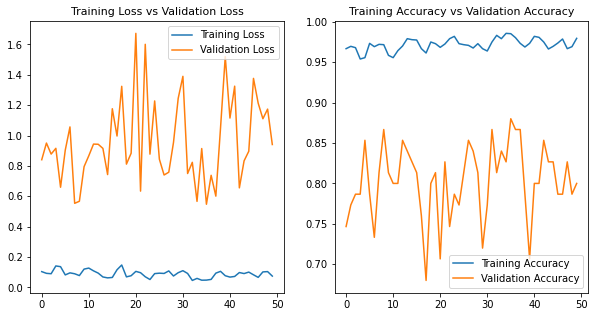

In [23]:
plot_loss_accuracy(history_24_saved,classifier_24)

In [29]:
classif_report(classifier_24)


<ipython-input-6-a88ff2ad379f>:4: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred=classifier.predict_generator(testing,verbose=1)


3/3 [==============================] - 0s 84ms/step
                            precision    recall  f1-score   support

           AMERICAN AVOCET       1.00      0.80      0.89         5
     ALTAMIRA YELLOWTHROAT       1.00      1.00      1.00         5
             ALPINE CHOUGH       1.00      1.00      1.00         5
      ALEXANDRINE PARAKEET       1.00      1.00      1.00         5
            ALBERTS TOWHEE       1.00      1.00      1.00         5
                 ALBATROSS       0.71      1.00      0.83         5
       AFRICAN PYGMY GOOSE       1.00      1.00      1.00         5
     AFRICAN PIED HORNBILL       1.00      0.80      0.89         5
    AFRICAN OYSTER CATCHER       1.00      1.00      1.00         5
         AFRICAN FIREFINCH       0.83      1.00      0.91         5
    AFRICAN EMERALD CUCKOO       0.83      1.00      0.91         5
     AFRICAN CROWNED CRANE       0.80      0.80      0.80         5
ABYSSINIAN GROUND HORNBILL       0.80      0.80      0.80      